# Linear regression project - predicting the sale price of homes

# Data exploration and feature design

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import h2o

In [3]:
# read in training and test data
housing_train = pd.read_csv('../data/processed/train_clean.csv', index_col = 'Id', keep_default_na = False)
housing_test = pd.read_csv('../data/processed/test_clean.csv', index_col = 'Id', keep_default_na = False)

## 1. Exploration of target variable

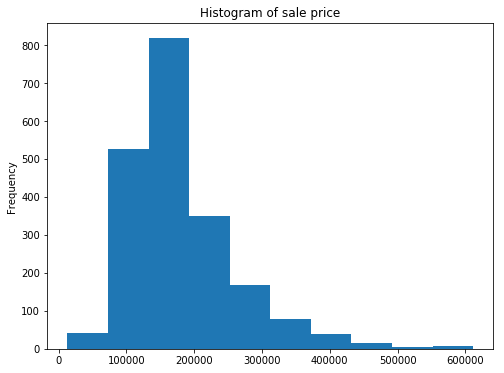

In [4]:
fig, ax = plt.subplots(figsize=(8,6))
housing_train['SalePrice'].plot(kind='hist', ax=ax)
ax.set_title('Histogram of sale price');

In [5]:
## Target variable is right skewed, whereas we want a normally distributed target for linear regression

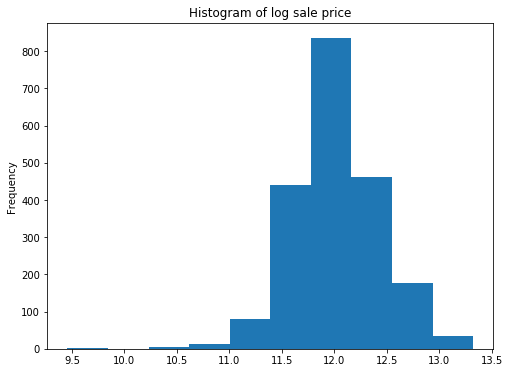

In [6]:
# log transform price to get a more normally distributed target
housing_train['Log Price'] = np.log(housing_train['SalePrice'])

fig, ax = plt.subplots(figsize=(8,6))
housing_train['Log Price'].plot(kind='hist', ax=ax)
ax.set_title('Histogram of log sale price');

## 2. Exploration of features

### Scatter plots

In [7]:
housing_train.shape

(2051, 81)

In [8]:
def scatter_plot(x,y,ax):
    ax.scatter(housing_train[x], housing_train[y], alpha=0.2)
    ax.set_title(y+' by '+x)
    try:
        ax.plot(np.unique(housing_train[x]), np.poly1d(np.polyfit(housing_train[x], housing_train[y], 1))(np.unique(housing_train[x])))
        correlation = round(np.corrcoef(housing_train[x], housing_train[y])[0,1],2)
        ax.annotate('Corr:'+str(correlation),xy=(housing_train[x].min(),housing_train[y].max()))
    except:
        pass
    ax.set_ylabel(y)
    ax.set_xlabel(x)

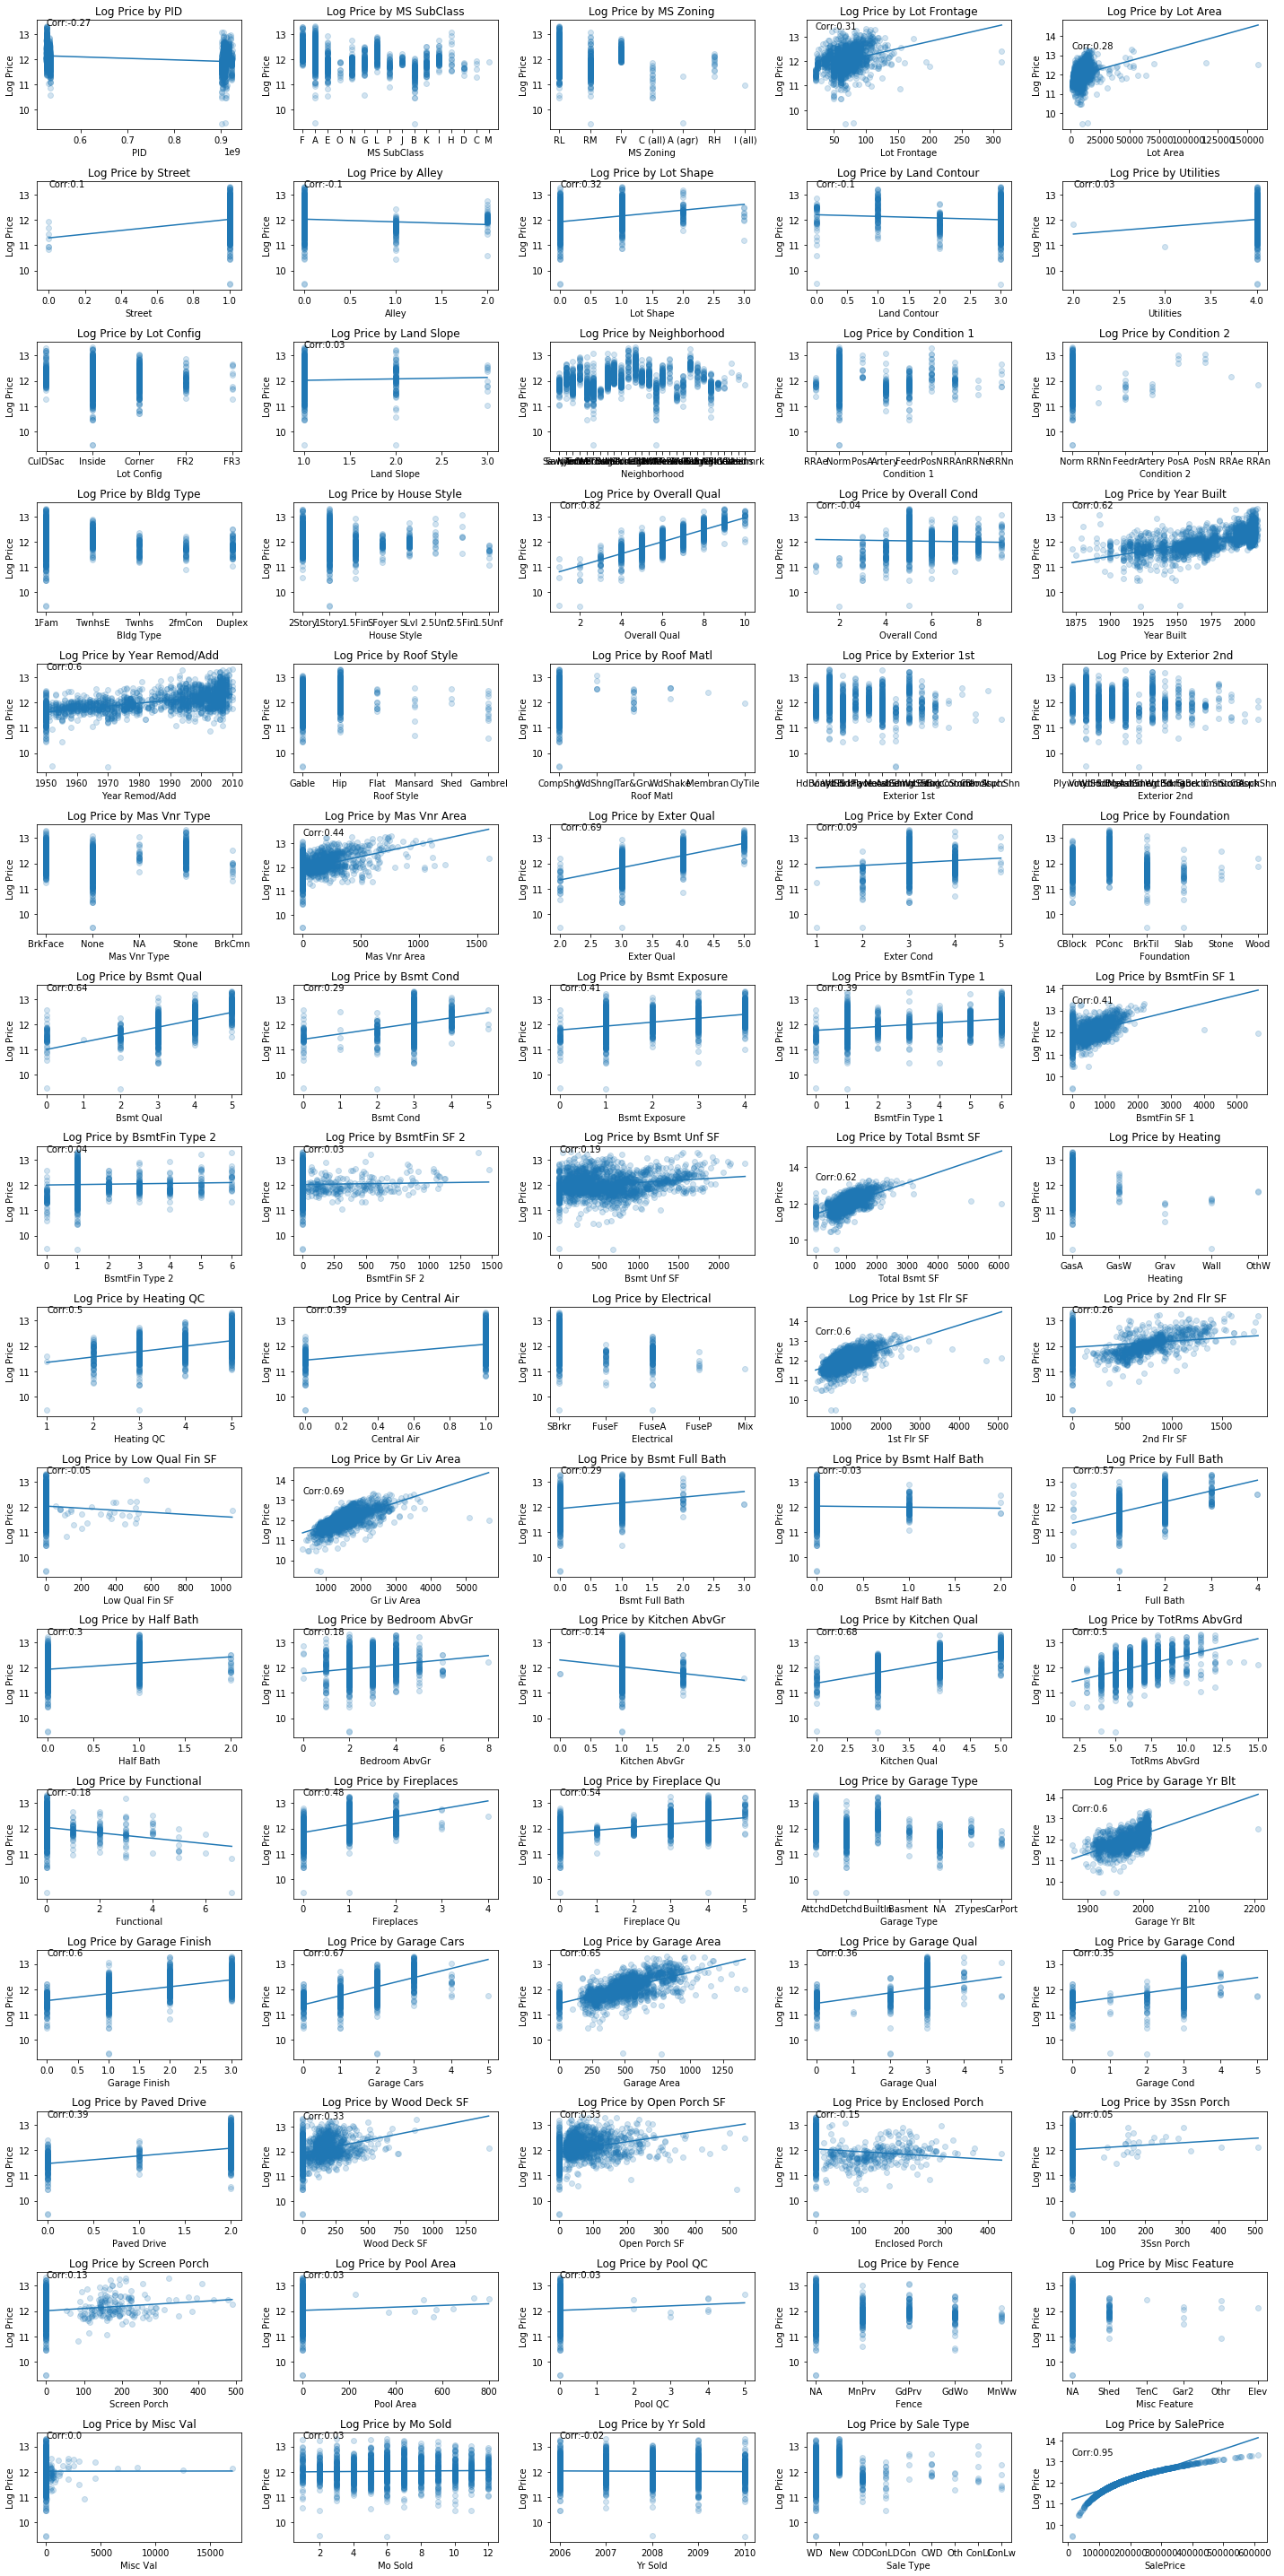

In [9]:
fig, ax = plt.subplots(16, 5, figsize=(20,40))
ax = ax.flatten()

for i, variable in enumerate(housing_train.drop(columns='Log Price').columns):
    scatter_plot(variable, 'Log Price', ax=ax[i])
    
plt.tight_layout()

In [10]:
# Observations:
# - Irrelevant features: PID
# - Poor predictive features: Utilities (not enough data), Street, Lot Shape, Lot Config, Condition 1/2, 
#     Roof style, Roof Matl, Mas Vnr Type, Heating, Low Qual Fin SF, Bmt Half Bath, Kitchen AbvGr,
#     Enclosed porch, 3Ssn porch, Pool Area, Pool QC, Misc Feature, Misc Value, Mo Sold, Yr Sold, 
# - Good predictive features: Lot Frontage, Lot Area, Overall Qual, Year Built, Year Remod/Add, Exter Qual, 
#     Bsmt Qual, Bsmt Cond, Bsmt Exposure, BsmtFin Type 1, Total Bsmt SF, Heating QC, Central Air, 1/2 Flr SF,
#     Gr Liv Area, Bsmt Full Bath, Full Bath, Half Bath, Kitchen Qual, TotRms AbvGrd, Functional, Fireplaces,
#     Fireplace Qu, Garage Yr Blt, Garage Finish, Garage Cars, Garage Area, Garage Qual, Garage Cond, Paved Drive,
#     Wood Deck SF, Open Porch SF, 
# - Unclear numerical relationship, but maybe categorical one: Alley
# - Categorical that need groups: MS Subclass, MS Zoning, Neighborhood, Exterior 1/2, Foundation, Electrical, 
#     Sale Type, House Style
# - Outliers: price, Lot Frontage, Lot Area, BsmtSF1, Total Bsmt SF, 1st Flr SF, Gr Liv Area, Wood Deck SF
# - Other: 
#     Perhaps two groups for lot area
#     Overall Cond has a lot of high priced 5's which appears to damage linear relationship
#     Year build may have exponential relationship
#     Year Remod/Add has strange lower bound of 1950
#     Exter Cond has a lot of high priced 3's which appears to damage linear relationship
#     Invalid value for Garage Yr Blt (~2200)

In [11]:
# drop PID
housing_train.drop(columns='PID', inplace=True)
housing_test.drop(columns='PID', inplace=True)

#### Data errors

In [12]:
# error in garage yr blt
select_columns = ['Garage Yr Blt', 'Garage Type', 'Year Built', 'Year Remod/Add', 'Yr Sold','Mo Sold']
housing_train.loc[housing_train['Garage Yr Blt']>2020, select_columns]

,Garage Yr Blt,Garage Type,Year Built,Year Remod/Add,Yr Sold,Mo Sold
Id,,,,,,
2261,2207.0,Attchd,2006,2007,2007,9


In [13]:
# assume this is a typo, and make best guess at correction
housing_train.loc[2261,'Garage Yr Blt'] = 2007

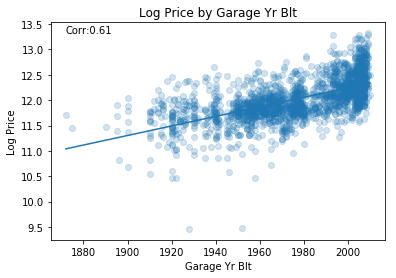

In [14]:
scatter_plot('Garage Yr Blt', 'Log Price', ax=plt.gca())

In [15]:
# check test data for errors
housing_test['Garage Yr Blt'].max()

2010.0

In [16]:
# lower bound on Year Remod/Add
select_columns = ['Year Built', 'Year Remod/Add', 'Garage Yr Blt']
housing_train.loc[housing_train['Year Remod/Add']==1950, select_columns].head(10)

,Year Built,Year Remod/Add,Garage Yr Blt
Id,,,
1311,1916,1950,1916.0
2860,1929,1950,1931.0
1537,1935,1950,1935.0
912,1928,1950,1981.0
1295,1920,1950,1920.0
1360,1930,1950,1930.0
2723,1924,1950,1924.0
1350,1927,1950,1920.0
1993,1910,1950,1920.0


In [17]:
# this seems to be some sort of imputation for missing data - replace with Garage Yr Build
# first making sure this is later that house year build
def clean_year_built(df):
    condition_1 = df['Year Remod/Add']==1950
    condition_2 = df['Year Built'] > df['Garage Yr Blt']
    
    df.loc[condition_1 & condition_2, 'Garage Yr Blt'] = df['Year Built']
    df.loc[condition_1, 'Year Remod/Add'] = df['Garage Yr Blt']
    
    return df

In [18]:
housing_train = clean_year_built(housing_train)

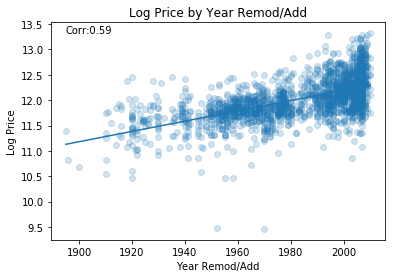

In [19]:
scatter_plot('Year Remod/Add', 'Log Price', ax=plt.gca())

In [20]:
# clean test data
housing_test = clean_year_built(housing_test)

#### Outliers

In [21]:
# Year Built and Gr Liv Area are strong predictive features (see later in notebook)

In [22]:
# remove outliers from trend between Year Built and Price
housing_train.drop(housing_train[housing_train['Log Price']<10].index, inplace=True)

In [23]:
# remove outliers from trend between Gr Liv Area and Price
housing_train.drop(housing_train[housing_train['Gr Liv Area']>4500].index, inplace=True)

### Ranking feature importance

#### Using correlations

In [24]:
feature_importance_corr = abs(housing_train.corr()['Log Price']).sort_values(ascending=False)

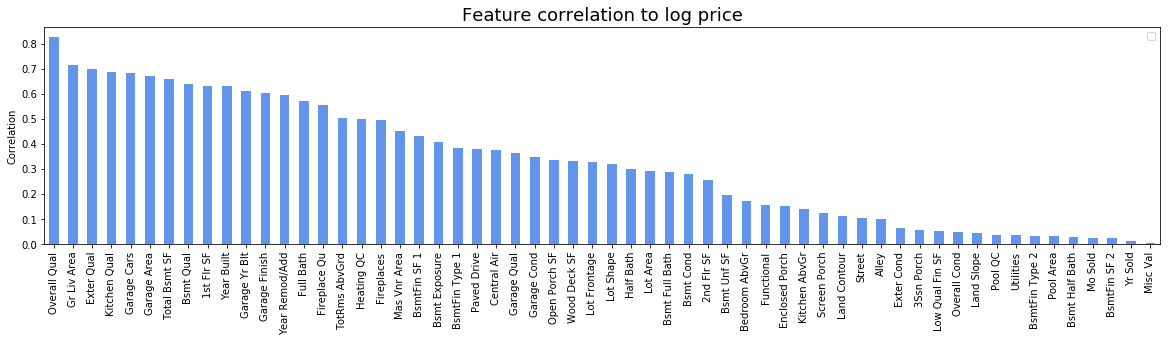

In [25]:
# plot feature importance
fig, ax = plt.subplots(figsize=(20,4))
feature_importance_corr[2:].plot.bar(color='cornflowerblue', ax=ax)
ax.set_title('Feature correlation to log price', fontsize=18)
ax.set_ylabel('Correlation')
ax.legend('');

#### Using a random forest

In [26]:
## ranking features helps to know where to focus efforts on feature engineering and selection
## correlations are important, but don't work for categories
## H20 random forest allows analysis of important features across categorical variables also

In [27]:
# connect to h2o by running in terminal:
# import h2o
# h2o.init()
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,14 days 4 hours 27 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.9
H2O cluster version age:,1 month
H2O cluster name:,H2O_from_python_emmalowe_w2bimz
H2O cluster total nodes:,1
H2O cluster free memory:,1.564 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [28]:
## the analysis above is useful, but only incorporates numerical variables
## H20 random forest allows analysis of important features across categorical variables also

In [29]:
# load dataframe into h2o frame
housing_train_h2oframe = h2o.H2OFrame(housing_train)

/anaconda3/envs/dsi/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [30]:
# build and train model
feature_columns = list(housing_train.drop(columns=['SalePrice', 'Log Price']).columns)
rf = h2o.estimators.H2ORandomForestEstimator()
rf.train(x=feature_columns, y='Log Price', training_frame=housing_train_h2oframe)

drf Model Build progress: |███████████████████████████████████████████████| 100%


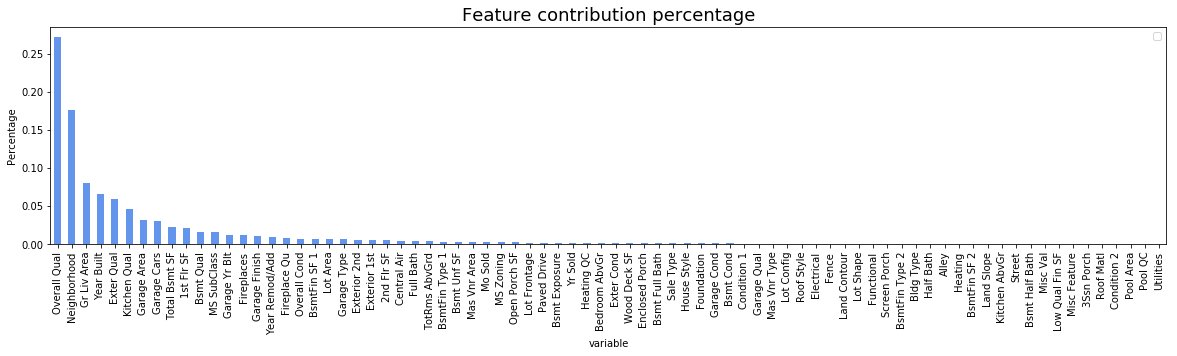

In [31]:
# get and plot feature importance
feature_importance_rf = rf._model_json['output']['variable_importances'].as_data_frame()
feature_importance_rf.set_index('variable', inplace = True)

fig, ax = plt.subplots(figsize=(20,4))
feature_importance_rf.plot.bar(use_index=True, y ='percentage', color='cornflowerblue', ax=ax)
ax.set_title('Feature contribution percentage', fontsize=18)
ax.set_ylabel('Percentage')
ax.legend('');

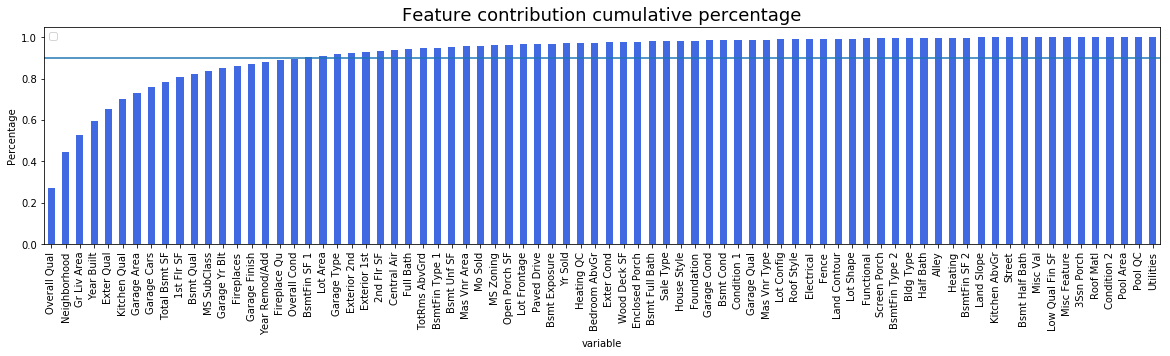

In [32]:
feature_importance_rf['cum_percentage'] = np.cumsum(feature_importance_rf['percentage'])
fig, ax = plt.subplots(figsize=(20,4))
feature_importance_rf.plot.bar(use_index=True, y ='cum_percentage', color='royalblue', ax=ax)
ax.set_title('Feature contribution cumulative percentage', fontsize=18)
ax.set_ylabel('Percentage')
ax.legend('');
plt.axhline(y = 0.9);

#### Relationship between the two measures

In [33]:
feature_importance_comb = pd.DataFrame(feature_importance_corr[2:])
feature_importance_comb.columns = ['corr']
feature_importance_comb['rf_perc'] = [feature_importance_rf.loc[idx,'percentage'] for idx in feature_importance_comb.index]

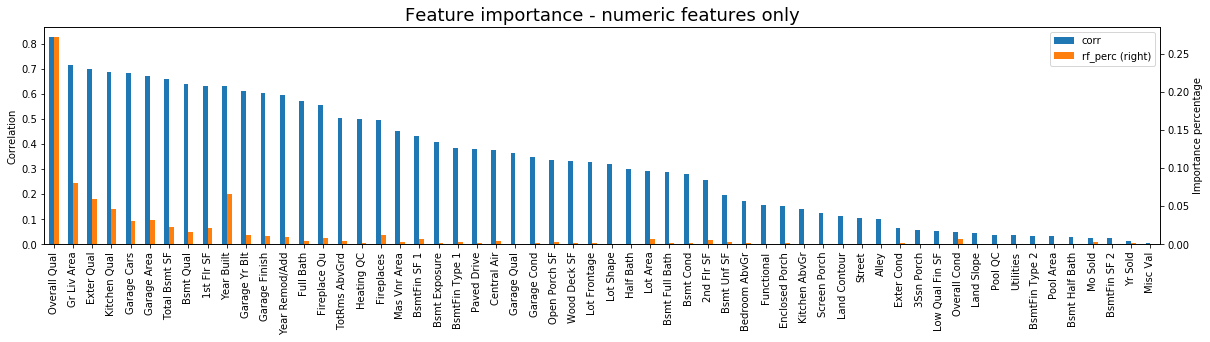

In [34]:
# plot feature importance
fig, ax = plt.subplots(figsize=(20,4))

feature_importance_comb.plot(kind='bar', ax=ax, secondary_y='rf_perc')

ax.set_title('Feature importance - numeric features only', fontsize=18)
ax.set_ylabel('Correlation')
ax.right_ax.set_ylabel('Importance percentage');

In [35]:
## both measures generally pick up most important and least important features

In [36]:
# shouldn't forget that correlations can't capture important categorical features
features_non_numeric = [feature for feature in feature_importance_rf.index if feature not in feature_importance_corr.index]

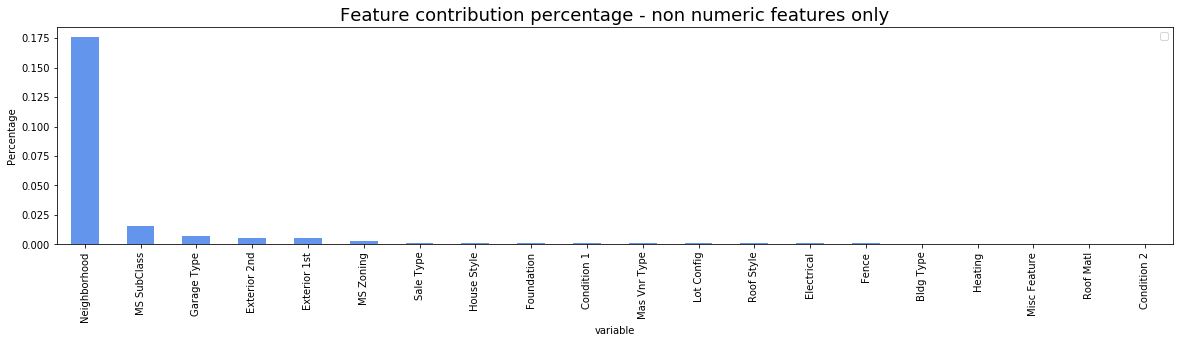

In [37]:
# get and plot feature importance
fig, ax = plt.subplots(figsize=(20,4))
feature_importance_rf.loc[features_non_numeric,:].plot.bar(use_index=True, y ='percentage', color='cornflowerblue', ax=ax)
ax.set_title('Feature contribution percentage - non numeric features only', fontsize=18)
ax.set_ylabel('Percentage')
ax.legend('');

## 3. Feature engineering

In [38]:
feature_importance_rf[feature_importance_rf['cum_percentage']<0.9]

,relative_importance,scaled_importance,percentage,cum_percentage
variable,,,,
Overall Qual,3554.714844,1.000000,0.271423,0.271423
Neighborhood,2300.264404,0.647102,0.175639,0.447062
Gr Liv Area,1058.136841,0.297671,0.080795,0.527857
Year Built,866.893616,0.243871,0.066192,0.594049
Exter Qual,781.013245,0.219712,0.059635,0.653684
Kitchen Qual,609.190308,0.171375,0.046515,0.700199
Garage Area,414.874390,0.116711,0.031678,0.731877
Garage Cars,394.893616,0.111090,0.030152,0.762030
Total Bsmt SF,291.166382,0.081910,0.022232,0.784262


In [39]:
## observations:
## - a quarter of variables explain 90% of variation in the model
## - important categorical data include Neighborhood and MS SubClass
## - quality and size seem to be important numerical features

### New features

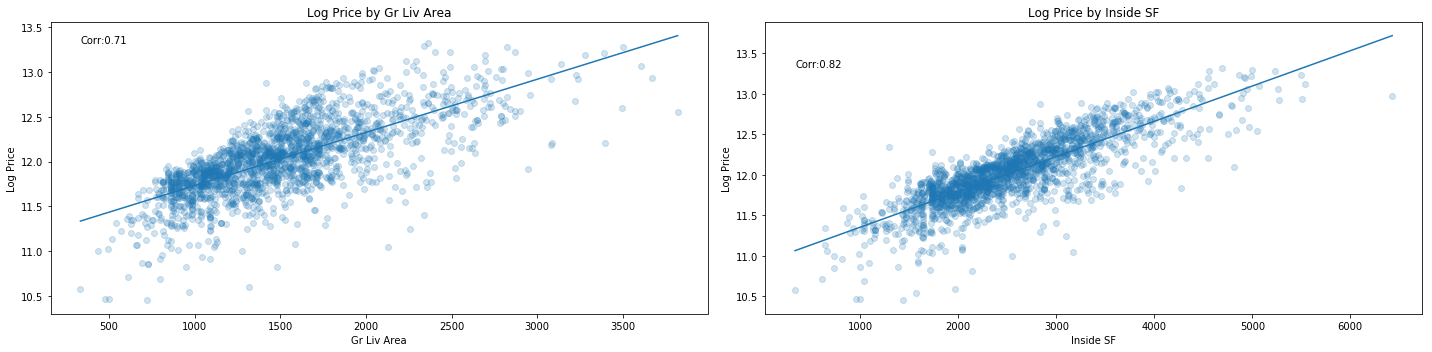

In [40]:
# SF features

# inside SF
inside_SF_columns = ['Total Bsmt SF', '1st Flr SF', '2nd Flr SF']
housing_train['Inside SF'] = housing_train[inside_SF_columns].sum(axis=1)

select_columns = ['Gr Liv Area', 'Inside SF']

fig, ax = plt.subplots(1, 2, figsize=(20,5))
for i, variable in enumerate(select_columns):
    scatter_plot(variable, 'Log Price', ax=ax[i])  
plt.tight_layout()

In [41]:
## New feature seems to be a better predictor
housing_test['Inside SF'] = housing_test[inside_SF_columns].sum(axis=1)

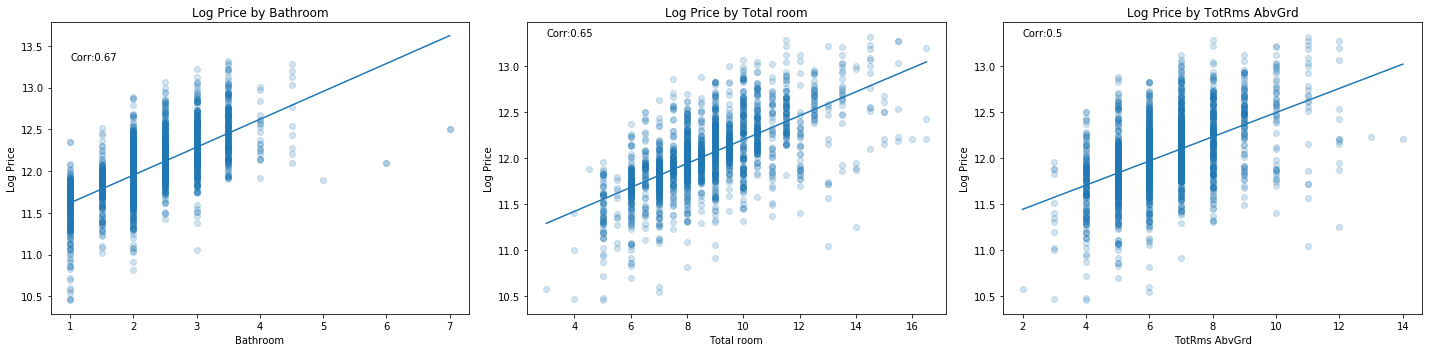

In [42]:
# num rooms

# total bathrooms
housing_train['Bathroom'] = housing_train['Full Bath'] + housing_train['Half Bath']/2 + housing_train['Bsmt Full Bath'] + housing_train['Bsmt Half Bath']/2

# total rooms
housing_train['Total room'] = housing_train['Bathroom'] + housing_train['TotRms AbvGrd']

select_columns = ['Bathroom', 'Total room', 'TotRms AbvGrd']

fig, ax = plt.subplots(1, 3, figsize=(20,5))
for i, variable in enumerate(select_columns):
    scatter_plot(variable, 'Log Price', ax=ax[i])  
plt.tight_layout()


In [43]:
## New features seem to be good predictors
housing_test['Bathroom'] = housing_test['Full Bath'] + housing_test['Half Bath']/2 + housing_test['Bsmt Full Bath'] + housing_test['Bsmt Half Bath']/2
housing_test['Total room'] = housing_test['Bathroom'] + housing_test['TotRms AbvGrd']

In [44]:
# porch

### Categorical groupings

In [45]:
## some categories have few data points, so it might be worth grouping some categories

In [46]:
def plot_groupby_means(group_by):
    
    fig, ax = plt.subplots()
    ax = plt.gca()
    
    # plot mean residual with error bars, grouped by category
    means = group_by['mean']
    means.plot.bar()
    
    # make some labels for number of observations
    rects = ax.patches
    labels = list(group_by['count'])

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

#### Neighborhood

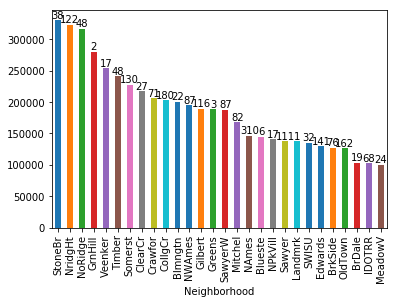

In [47]:
# plotting by sale price, not log sale price, makes distinctions easier to see
groupby_neighborhood = housing_train.groupby('Neighborhood')['SalePrice'].agg(['mean', 'count'])
groupby_neighborhood = groupby_neighborhood.sort_values(by='mean', ascending=False)

plot_groupby_means(groupby_neighborhood)

In [48]:
## seem to be 4 main pricing groups, that we can turn into features
neighborhood_groups = ['A']*3+['B']*12+['C']*10+['D']*3
neighborhood_map = dict(zip(groupby_neighborhood.index, neighborhood_groups))
    
housing_train['Neighborhood Group'] = housing_train['Neighborhood'].map(neighborhood_map)
housing_test['Neighborhood Group'] = housing_test['Neighborhood'].map(neighborhood_map)

#### MS SubClass

In [49]:
# MS Subclass contains mixed information, most of which is already available in other features
# e.g. House Style (how many stories/split levels), Year Built, Blg Type

# House Style also contains mixed information on stories and finish

In [50]:
housing_train['House Style'].value_counts()

1Story    1056
2Story     597
1.5Fin     218
SLvl        94
SFoyer      50
2.5Unf      14
1.5Unf      12
2.5Fin       6
Name: House Style, dtype: int64

In [51]:
# create new features for stories, finish and PUD/non-PUD (not captured in Bldg Type)

In [52]:
# finish
unfinished_styles = ['2.5Unf', '1.5Unf']
unfinished_subclasses = ['D']

In [53]:
def create_finish_feature(df):
    df['Finish'] = 1
    
    df['Finish'] = df['House Style'].map(lambda x: x not in unfinished_styles)*df['Finish']
    df['Finish'] = df['MS SubClass'].map(lambda x: x not in unfinished_subclasses)*df['Finish']
    df['Finish'] = df['Bsmt Unf SF'].map(lambda x: x!=0)*df['Finish']

    return df

In [54]:
housing_train = create_finish_feature(housing_train)
housing_test = create_finish_feature(housing_test)

In [55]:
# num stories
story_map = {'1Story':'1Story', '2Story':'2Story', '1.5Fin':'1.5Story', 'SLvl':'Split', 
             'SFoyer':'Split','2.5Unf':'2.5Story', '1.5Unf':'1.5Story', '2.5Fin':'2.5Story'}

housing_train['Stories'] = housing_train['House Style'].map(story_map)
housing_test['Stories'] = housing_test['House Style'].map(story_map)

In [56]:
# PUD
PUD_subclasses = ['L','M','N','O']
housing_train['PUD'] = housing_train['MS SubClass'].map(lambda x: x in PUD_subclasses)*1
housing_test['PUD'] = housing_test['MS SubClass'].map(lambda x: x in PUD_subclasses)*1

#### MS Zoning

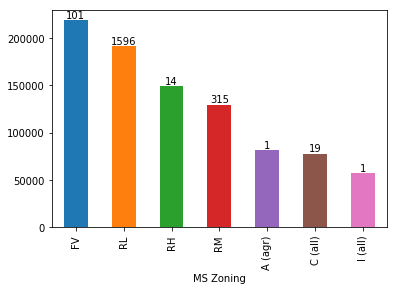

In [57]:
# MS Zoning
# RL, RH, FV, Other

groupby_zone = housing_train.groupby('MS Zoning')['SalePrice'].agg(['mean', 'count'])
groupby_zone = groupby_zone.sort_values(by='mean', ascending=False)

plot_groupby_means(groupby_zone);

In [58]:
## group low counts together - RH with RM and non-residential together
zone_map = {'FV':'FV', 'RL':'RL', 'RH':'RH', 'RM':'RH', 'A (agr)':'NonR', 'C (all)':'NonR', 'I (all)':'NonR'}
    
housing_train['Zone Group'] = housing_train['MS Zoning'].map(zone_map)
housing_test['Zone Group'] = housing_test['MS Zoning'].map(zone_map)

### Transforms

In [59]:
def check_log_transform(variable):
    correlation = np.corrcoef((housing_train[variable]), housing_train['Log Price'])[0,1]
    transform_correlation = np.corrcoef(np.log(housing_train[variable]), housing_train['Log Price'])[0,1]
    print('Correlation between '+variable+' and Log Price: ', correlation) 
    print('Correlation between Log '+variable+' and Log Price: ', transform_correlation)

In [60]:
# check whether tranform on Year Built would improve correlation
check_log_transform('Year Built')

Correlation between Year Built and Log Price:  0.6303884707919358
Correlation between Log Year Built and Log Price:  0.6284604348557257


In [61]:
# check whether tranform on Garage Yr Blt Built would improve correlation
check_log_transform('Garage Yr Blt')

Correlation between Garage Yr Blt and Log Price:  0.6131949474211099
Correlation between Log Garage Yr Blt and Log Price:  0.611876976351622


In [62]:
# check whether tranform on Year Remod/Add would improve correlation
check_log_transform('Year Remod/Add')

Correlation between Year Remod/Add and Log Price:  0.59478434041954
Correlation between Log Year Remod/Add and Log Price:  0.5941723863145476


In [63]:
## all untransformed variables have stronger correlation with Log Price than transformed counterpart
## therefore no feature engineering is needed

## 4. Feature selection

###  Unimportant features

In [64]:
feature_importance_rf.tail(20)

,relative_importance,scaled_importance,percentage,cum_percentage
variable,,,,
Screen Porch,9.198915,0.002588,0.000702,0.995153
BsmtFin Type 2,8.839681,0.002487,0.000675,0.995828
Bldg Type,8.264189,0.002325,0.000631,0.996459
Half Bath,8.170089,0.002298,0.000624,0.997083
Alley,7.058405,0.001986,0.000539,0.997622
Heating,5.932265,0.001669,0.000453,0.998075
BsmtFin SF 2,5.030991,0.001415,0.000384,0.998459
Land Slope,3.859278,0.001086,0.000295,0.998754
Kitchen AbvGr,3.451885,0.000971,0.000264,0.999017


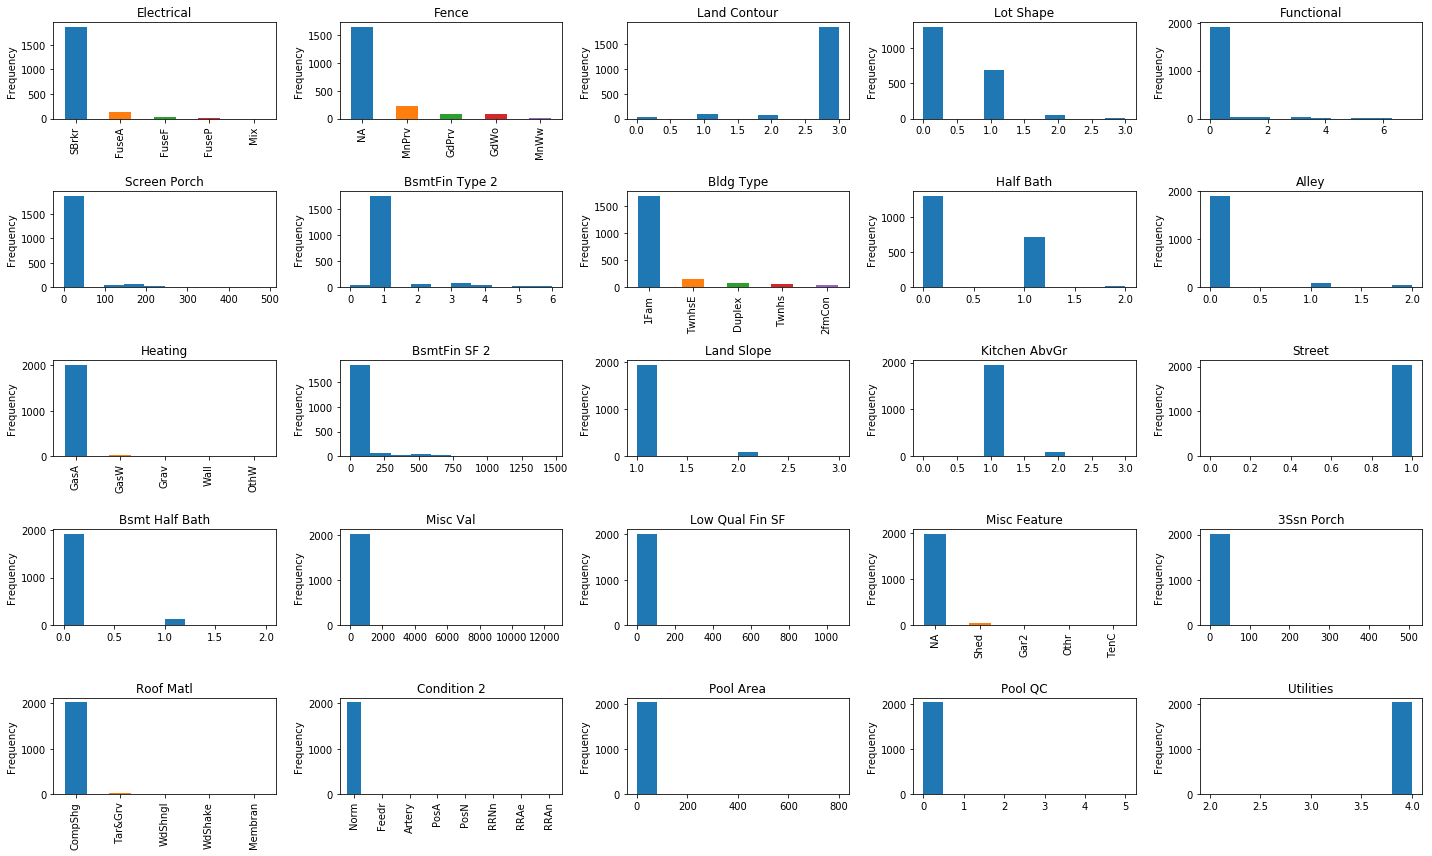

In [65]:
fig, ax = plt.subplots(5, 5, figsize=(20,12))
ax = ax.flatten()

for i, variable in enumerate(feature_importance_rf.tail(25).index):
    try:
        housing_train[variable].plot.hist(ax=ax[i])
    except:
        housing_train[variable].value_counts().plot.bar(ax=ax[i])
    ax[i].set_title(variable)
    ax[i].set_ylabel('Frequency')
    
plt.tight_layout()

In [66]:
## most low importance features are heavily dominated by one category
## linear regression on categories that have a low number of points is likely to lead to overfitting

In [67]:
# Features identified as poor predictors from scatter plots include: 
poor_predictive_features = ['Utilities', 'Street', 'Lot Shape', 'Lot Config', 'Condition 1', 'Condition 2', 
                            'Roof Style','Roof Matl', 'Mas Vnr Type', 'Heating', 'Low Qual Fin SF', 'Bsmt Half Bath',
                            'Kitchen AbvGr','Enclosed Porch', '3Ssn Porch', 'Pool Area', 'Pool QC', 
                            'Misc Feature', 'Misc Val', 'Mo Sold', 'Yr Sold']

low_importance_features = feature_importance_rf.tail(16).index

# combine two sets of features

features_to_drop = set(poor_predictive_features).union(set(low_importance_features))

In [68]:
# drop these features
housing_train.drop(columns = features_to_drop, inplace = True)
housing_test.drop(columns = features_to_drop, inplace = True)

### Replaced features

In [69]:
# drop features that are now irrelevant after feature engineering
features_to_drop = ['Total Bsmt SF','1st Flr SF','2nd Flr SF','Gr Liv Area',
                  'TotRms AbvGrd','Full Bath','Half Bath','Bsmt Full Bath','Bsmt Half Bath',
                   'Neighborhood','House Style', 'MS SubClass','MS Zoning']

# some features may have been dropped already - adjust list for this
features_to_drop = set(features_to_drop).intersection(set(housing_train.columns))

# drop these features
housing_train.drop(columns = features_to_drop, inplace = True)
housing_test.drop(columns = features_to_drop, inplace = True)

### Collinearity

In [70]:
collinearity_matrix = abs(housing_train.drop(columns=['SalePrice','Log Price']).corr())

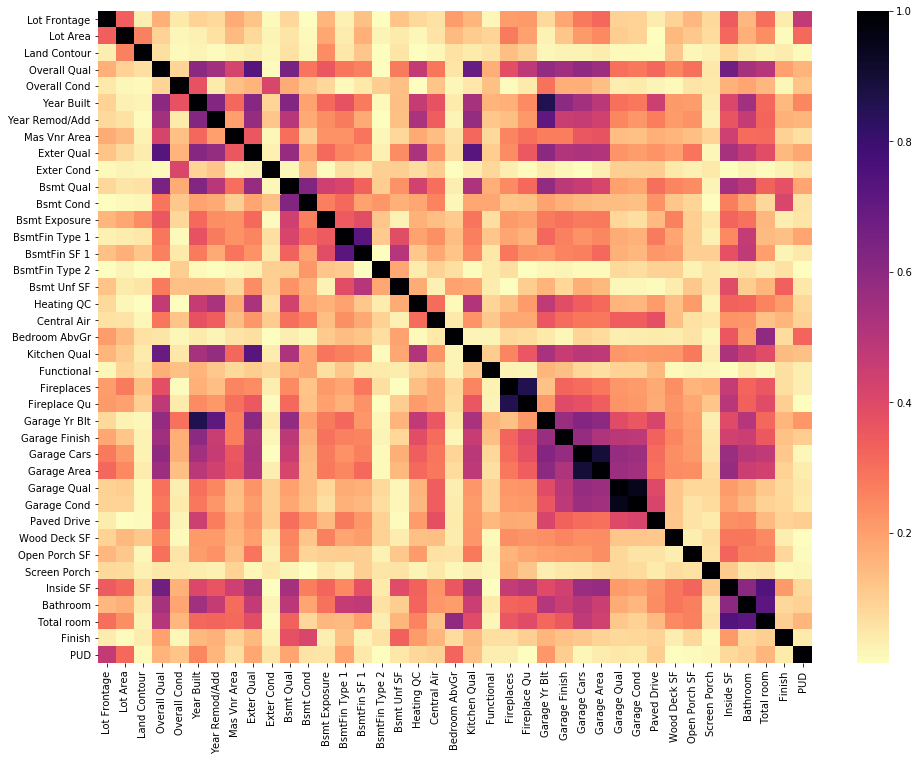

In [71]:
# plot heatmap
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(collinearity_matrix, cmap='magma_r');

In [72]:
## some strong multicollinearity between variables (e.g. Garage Cars and Garage Area)

In [73]:
# analysis of collinear pairs

# get list of highly collinear pairs
collinearity_matrix = collinearity_matrix.mask(np.tril(np.ones(collinearity_matrix.shape)).astype(np.bool))
collinear_pairs = collinearity_matrix[collinearity_matrix >= 0.8].stack().reset_index()
collinear_pairs.columns = ['A', 'B', 'Corr(A,B)']

# add correlation with log price to table to see which of the pair correlates better
corr_lambda = lambda x: np.corrcoef(housing_train[x], housing_train['Log Price'])[0,1]
collinear_pairs['Corr(A,Log Price)'] = collinear_pairs['A'].map(corr_lambda)
collinear_pairs['Corr(B,Log Price)'] = collinear_pairs['B'].map(corr_lambda)

collinear_pairs

,A,B,"Corr(A,B)","Corr(A,Log Price)","Corr(B,Log Price)"
0,Year Built,Garage Yr Blt,0.857187,0.630388,0.613195
1,Fireplaces,Fireplace Qu,0.860744,0.495708,0.554088
2,Garage Cars,Garage Area,0.897583,0.682241,0.672460
3,Garage Qual,Garage Cond,0.950857,0.363907,0.348028


In [74]:
# Garage Yr Blt not as important as Year Built and Year Remod/Add
# Fireplace Qu better predictor than Fireplaces
# Garage Cars better predictor than Garage Area
# Garage Qual better predictor than Garage Cond

features_to_drop = ['Garage Yr Blt','Fireplaces','Garage Area','Garage Cond']

# drop these features
housing_train.drop(columns = features_to_drop, inplace = True)
housing_test.drop(columns = features_to_drop, inplace = True)

# 5. Save new features

In [75]:
housing_train.to_csv('../data/processed/train_features.csv')
housing_test.to_csv('../data/processed/test_features.csv')